In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython import display
import import_ipynb
from util import utils

# 环境

In [2]:
# env = utils.CartPoleEnv(max_step=200, failure_score=-1000)
env = utils.CartPoleEnv()
state = env.reset(seed=0)

# 算法定义

## 策略网络

In [3]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        # x: (batch_size, state_dim)变为(batch_size, hidden_dim)
        x = F.relu(self.fc1(x))
        # (batch_size, action_dim)
        return F.softmax(self.fc2(x), dim=1)

## REINFORCE类

In [4]:
class REINFORCE:
    name = 'REINFORCE'
    def __init__(self, state_dim, hidden_dim, action_dim, lr, gamma,
                 device):
        self.policy_net = PolicyNet(state_dim, hidden_dim,
                                    action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(),
                                          lr=lr)  # 使用Adam优化器
        self.gamma = gamma  # 折扣因子
        self.device = device

    def take_action(self, state):  # 根据动作概率分布随机采样
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):  # 从最后一步算起
            reward = reward_list[i]
            state = torch.tensor(np.array([state_list[i]]),
                                 dtype=torch.float).to(self.device)
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)
            log_prob = torch.log(self.policy_net(state).gather(1, action))
            G = self.gamma * G + reward
            loss = -log_prob * G  # 每一步的损失函数
            loss.backward()  # 反向传播计算梯度
        self.optimizer.step()  # 梯度下降
        
    def play(self, env, update=False, show=False):
        episode_return = 0
        transition_dict = {
            'states': [], 
            'actions': [], 
            'next_states': [], 
            'rewards': [], 
            'dones': []
        }
        state = env.reset()
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, done = env.step(action)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            state = next_state
            episode_return += reward
            if show:
                display.clear_output(wait=True)
                env.show()
        if update: 
            agent.update(transition_dict)
        return episode_return

# 初始化

In [5]:
torch.manual_seed(0)

In [6]:
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.n
lr = 1e-3
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
agent = REINFORCE(state_dim, hidden_dim, action_dim, lr, gamma,
                  device)

In [7]:
num_episodes = 1000
epochs = 10

# 玩一局游戏（训练前）

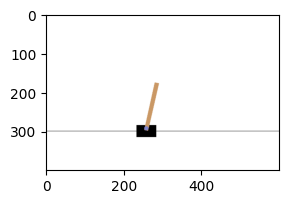

回报：33.0


In [8]:
episode_return = agent.play(env, update=False, show=True)
print("回报：{}".format(episode_return))

# 算法训练

## 训练过程

In [9]:
def train(env, agent, num_episodes, epochs):
    return_list = [] # 记录每一条序列的回报
    update = True
    show = False
    for i in range(epochs): # 显示epochs个进度条
        with tqdm(total=int(num_episodes / epochs), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / epochs)):  # 每个进度条的序列数
                episode_return = agent.play(env, update, show)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

In [10]:
return_list = train(env=env, agent=agent, num_episodes=num_episodes, epochs=epochs)

Iteration 9: 100%|█████████████████████████████████████| 100/100 [06:52<00:00,  4.13s/it, episode=1000, return=364.600]


## 训练结果

### 训练回报

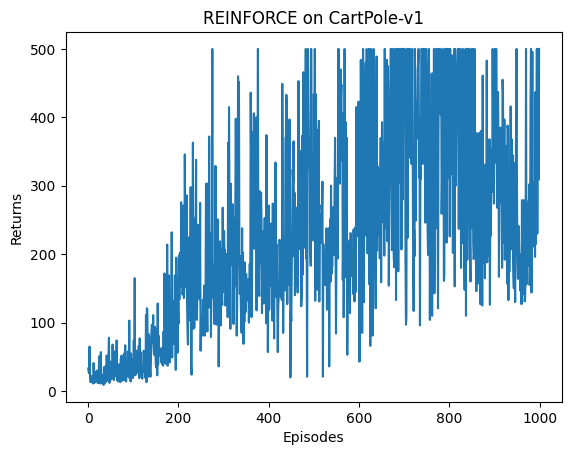

In [11]:
utils.show_return(return_list, agent, env)

### 训练移动平均回报

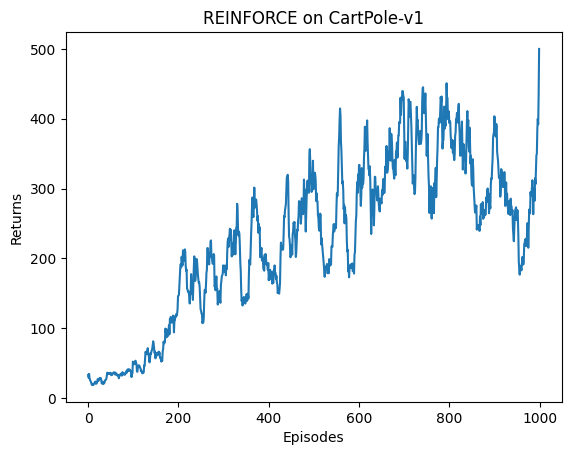

In [12]:
mv_return = utils.moving_average(return_list, 9)
utils.show_return(mv_return, agent, env)

# 再玩一局游戏（训练后）

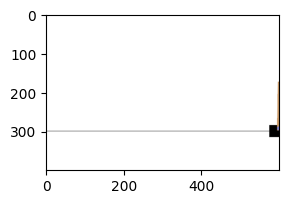

回报：345.0


In [13]:
episode_return = agent.play(env, update=False, show=True)
print("回报：{}".format(episode_return))